In [1]:
import os
import sys
import warnings

Path = '/remote/tychodata/ftairli/work/Projects/LSTM_Reconstruction/Models'
if Path not in sys.path: sys.path.append(Path)
warnings.filterwarnings('ignore')

from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch


hostname = os.uname()
if 'tedtop' in hostname: sys.path.append('/home/fedor-tairli/work/CDEs/Dataset/')


from Dataset2 import ProcessingDatasetContainer

if 'tedtop' in hostname: plt.style.use('/home/fedor-tairli/work/MPLStylefiles/Vscode_DarkModern_Invisible.mplstyle')



In [12]:
Model_Name   = 'Model_SDP_Conv3d_JustEnergy'
Dataset_Name = 'XmaxEnergy_Conv3d_Dataset'

In [13]:
hostname

posix.uname_result(sysname='Linux', nodename='tycho.physics.adelaide.edu.au', release='3.10.0-1160.88.1.el7.x86_64', version='#1 SMP Tue Mar 7 15:41:52 UTC 2023', machine='x86_64')

#### Loading Data and Models, Processing Predictions

In [14]:
if 'tycho' in hostname or 'tycho' in hostname.nodename:
    Models_Path  = '/remote/tychodata/ftairli/work/CDEs/XmaxEnergy/Models'
    Dataset_Path = '/remote/tychodata/ftairli/work/CDEs/XmaxEnergy/Data/'
if 'tedtop' in hostname:
    Models_Path  = '/home/fedor-tairli/work/CDEs/XmaxEnergy/Models'
    Dataset_Path = '/home/fedor-tairli/work/CDEs/XmaxEnergy/Data/'

# append models path to path
sys.path.append(Models_Path)


In [15]:
# Load Model and Tracker Here
Model = torch.load(f'{Models_Path}/{Model_Name}.pt')
Tracker = torch.load(f'{Models_Path}/{Model_Name}_Tracker.pt')
print(Model.Description)


    Convolutional Neural Network for SDP Reconstruction
    Only the Phi is learned
    


In [16]:
# Import Dataset Here

# datapath = '/remote/tychodata/ftairli/work/Projects/ProfileReconstruction/Data/'
# Dataset = ProcessingDatasetContainer(datapath)
Dataset = torch.load(f'{Dataset_Path}/{Dataset_Name}.pt')
print(Dataset.Name)
print(Dataset.Truth_Keys)
print(f'Dataset Length : {len(Dataset)}')
Dataset.AssignIndices()
Dataset.State = 'Test'

Unassigned_CDEsDataset
('Xmax', 'LogE')
Dataset Length : 375911


In [17]:
# Some Information
print(f'Final Epoch             : {len(Tracker.EpochLoss["Total"])  } ')
if len(Tracker.EpochLoss)>10 :
    print(f'Epoch 10 Loss           : {Tracker.EpochLoss    ["Total"][9]} ')
    print(f'Epoch 10 Validation Loss: {Tracker.EpochValLoss ["Total"][9]} ')
print(f'Final Loss              : {Tracker.EpochLoss    ["Total"][-1]}')
print(f'Final Validation Loss   : {Tracker.EpochValLoss ["Total"][-1]}')


Final Epoch             : 12 
Final Loss              : 1.4054646613329997
Final Validation Loss   : 1.4976518154144287


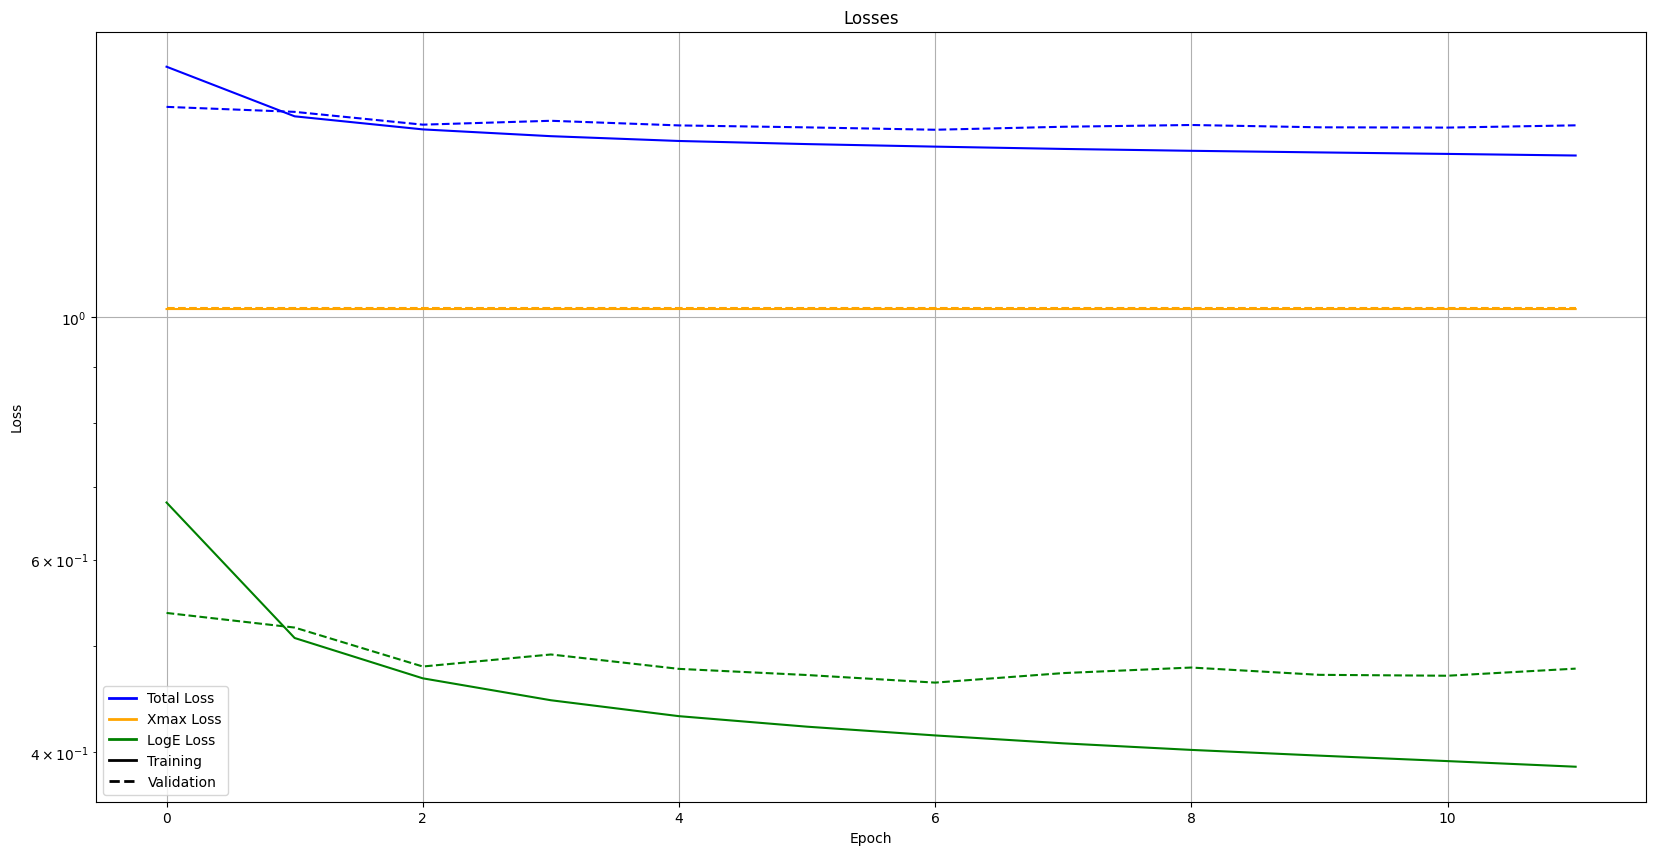

In [18]:
# Loss Plot
EpochLosses    = Tracker.EpochLoss
EpochValLosses = Tracker.EpochValLoss
Keys = list(EpochLosses.keys())
Nepochs = len(EpochLosses[Keys[0]])

ax = plt.figure(figsize=(20, 10)).gca()

# Define colors
colors = ['blue', 'orange', 'green', 'red','cyan','purple','magenta','yellow']


custom_lines = []
custom_keys  = []
for i in range(len(Keys)):
    plt.plot(EpochLosses[Keys[i]]   , color=colors[i], label=Keys[i] + ' - Training')
    plt.plot(EpochValLosses[Keys[i]], color=colors[i], label=Keys[i] + ' - Validation', linestyle='dashed')
    custom_lines.append(Line2D([0], [0], color=colors[i], lw=2))
    custom_keys.append(Keys[i]+' Loss')

custom_lines+= [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='black', lw=2, linestyle='dashed')]
custom_keys += ['Training', 'Validation']


ax.legend(custom_lines, custom_keys)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True)) # integer ticks
ax.set_title('Losses')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.grid()

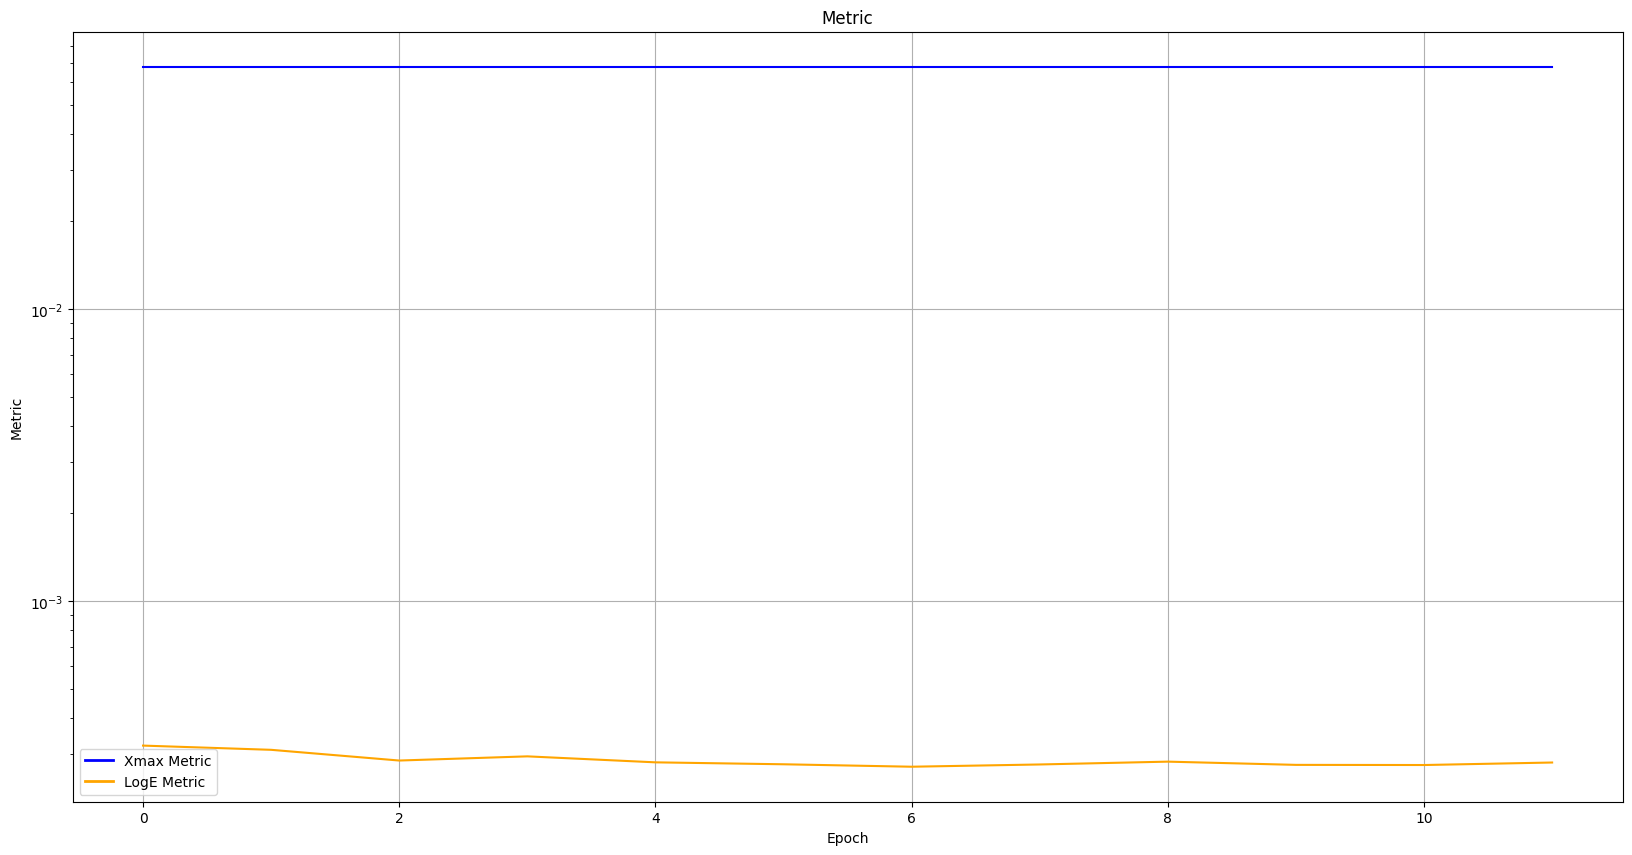

In [19]:
# Metric Plot

# Loss Plot
EpochMetrics    = Tracker.EpochMetric
Keys  = Dataset.Truth_Keys
Units = Dataset.Truth_Units
Nepochs = len(EpochLosses[Keys[0]])

ax = plt.figure(figsize=(20, 10)).gca()

# Define colors
colors = ['blue', 'orange', 'green', 'red','cyan','purple','magenta','yellow']


custom_lines = []
custom_keys  = []
for i in range(len(Keys)):
    if   Units[i] == 'deg': plt.plot(np.array(EpochMetrics[Keys[i]]), color=colors[i], label=Keys[i] + ' - Metric')
    elif Units[i] == 'rad': plt.plot(np.array(EpochMetrics[Keys[i]])*180/np.pi, color=colors[i], label=Keys[i] + ' - Metric')
    else                  : plt.plot(np.array(EpochMetrics[Keys[i]])/1000     , color=colors[i], label=Keys[i] + ' - Metric')
    custom_lines.append(Line2D([0], [0], color=colors[i], lw=2))
    custom_keys.append(Keys[i]+' Metric')



ax.legend(custom_lines, custom_keys)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True)) # integer ticks
ax.set_title('Metric')
ax.set_xlabel('Epoch')
ax.set_ylabel('Metric')
ax.set_yscale('log')
ax.grid()

In [20]:
# Define some metrics
def MeanSquaredError(Truths,Predictions):
    return ((Truths-Predictions)**2).mean()
def MeanAbsoluteError(Truths,Predictions):
    return (np.abs(Truths-Predictions)).mean() if type(Truths) != torch.Tensor else (torch.abs(Truths-Predictions)).mean()
def Percentile68(Truths,Predictions):
    return np.percentile(np.abs(Truths-Predictions),68) if type(Truths) != torch.Tensor else torch.quantile(torch.abs(Truths-Predictions),0.68)

In [21]:
# Compute the Test Set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
Model.to(device)
torch.cuda.empty_cache()

Dataset.State      = 'Test'
# Dataset.BatchSize  = len(Dataset)//256
Dataset.BatchSize  = 64
Dataset.RandomIter = False
Truth = []
Pred  = []
Rec   = []
Model.eval()
EvI = 0
with torch.no_grad():
    for EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec in Dataset:
        # print(f'Event {EvI}/{len(Dataset)}', end='\r')
        # Send to device
        # BatchMains = [Main.to(device) for Main in BatchMains]
        # BatchAux   = BatchAux.to(device)
        # BatchAux[] = Dataset._Aux.mean(dim=0)

        Truth .append(BatchTruth)
        Pred  .append(Model(BatchMains, BatchAux).cpu())
        Rec   .append(BatchRec)
        EvI+=1
print()
Truth = torch.cat(Truth, dim=0)
Pred  = torch.cat(Pred , dim=0)
Rec   = torch.cat(Rec  , dim=0)

print(f'Pred Loss {MeanSquaredError(Truth,Pred)}')
print(f'Rec  Loss {MeanSquaredError(Truth,Rec )}')

Truth = Dataset.Unnormalise_Truth(Truth)
Pred  = Dataset.Unnormalise_Truth(Pred)
Rec   = Dataset.Unnormalise_Truth(Rec)

# drop NaN values
if True:
    # Looking for nans, sum up all of 2nd dim
    WeirdSum = Truth.sum(dim=1) + Pred.sum(dim=1) + Rec.sum(dim=1)
    Mask = ~torch.isnan(WeirdSum)
    print(f'Dropping {len(Truth) - Mask.sum()} NaN values')
    Truth = Truth[Mask]
    Pred  = Pred [Mask]
    Rec   = Rec  [Mask]
    NanLocs = torch.where(Mask==0)
    print(f' Nan Locations {NanLocs}')

# Remove Bad events
if False:
    Mask = (torch.abs(Truth[:,0]-Rec[:,0]) < 1) & (torch.abs(Truth[:,1]-Rec[:,1]) < 1000)
    print(f'Dropping {len(Truth) - Mask.sum()} Bad events')
    Truth = Truth[Mask]
    Pred  = Pred [Mask]
    Rec   = Rec  [Mask]


Truth = Truth.numpy()
Pred  = Pred .numpy()
Rec   = Rec  .numpy()


print(Truth.shape)
print(Pred.shape)




Pred Loss 0.7461493611335754
Rec  Loss inf
Dropping 0 NaN values
 Nan Locations (tensor([], dtype=torch.int64),)
(37592, 2)
(37592, 2)


In [22]:
# Compute Metric
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units

Pred68 = []
Rec68  = []

if "SDPTheta_c" in TruthKeys and "SDPPhi_c" in TruthKeys:
    # The Unnormalise_Truth will return SDPTheta and SDPPhi values, not c/s of either
    TruthKeys  = ['SDPTheta','SDPPhi']
    TruthUnits = ['rad','rad']  # Default Units for SDPTheta and SDPPhi

    


for i in range(len(TruthKeys)):
    if TruthUnits[i] == 'rad': 
        AngDivPred = np.arctan2(np.sin(Truth[:,i]-Pred[:,i]),np.cos(Truth[:,i]-Pred[:,i]))
        AngDivRec  = np.arctan2(np.sin(Truth[:,i]-Rec[:,i] ),np.cos(Truth[:,i]-Rec[:,i] ))
        Pred68.append(np.percentile(np.abs(AngDivPred),68))
        Rec68 .append(np.percentile(np.abs(AngDivRec ),68))
    elif TruthUnits[i] == 'deg':
        AngDivPred = np.arctan2(np.sin(np.deg2rad(Truth[:,i]-Pred[:,i])),np.cos(np.deg2rad(Truth[:,i]-Pred[:,i])))
        AngDivRec  = np.arctan2(np.sin(np.deg2rad(Truth[:,i]-Rec[:,i] )),np.cos(np.deg2rad(Truth[:,i]-Rec[:,i] )))
        Pred68.append(np.rad2deg(np.percentile(np.abs(AngDivPred),68)))
        Rec68 .append(np.rad2deg(np.percentile(np.abs(AngDivRec ),68)))
    else:
        Pred68.append(np.percentile(np.abs(Truth[:,i]-Pred[:,i]),68))
        Rec68 .append(np.percentile(np.abs(Truth[:,i]-Rec [:,i]),68))

# Print Out the values
    
for i in range(len(TruthKeys)):
    if TruthUnits[i] == 'rad': # Convert to degrees
        print(f'Adjusted Percentile for Pred {(TruthKeys[i]+"                          ")[:10]} {Pred68[i]*180/np.pi:.5} deg')
        print(f'Adjusted Percentile for Rec  {(TruthKeys[i]+"                          ")[:10]} {Rec68[i] *180/np.pi:.5} deg')
        print(f'Percentile Ratio   Pred/Rec             {Pred68[i]/Rec68[i]:.5}')
        print()
    else:
        print(f'Adjusted Percentile for Pred {(TruthKeys[i]+"                          ")[:10]} {Pred68[i]:.5} {TruthUnits[i]}')
        print(f'Adjusted Percentile for Rec  {(TruthKeys[i]+"                          ")[:10]} {Rec68[i] :.5} {TruthUnits[i]}')
        print(f'Percentile Ratio   Pred/Rec             {Pred68[i]/Rec68[i]:.5}')
        print()

Adjusted Percentile for Pred Xmax       67.806 g/cm^2
Adjusted Percentile for Rec  Xmax       276.01 g/cm^2
Percentile Ratio   Pred/Rec             0.24567

Adjusted Percentile for Pred LogE       0.28157 
Adjusted Percentile for Rec  LogE       0.45289 
Percentile Ratio   Pred/Rec             0.62171



#### Not particularly interesing plots

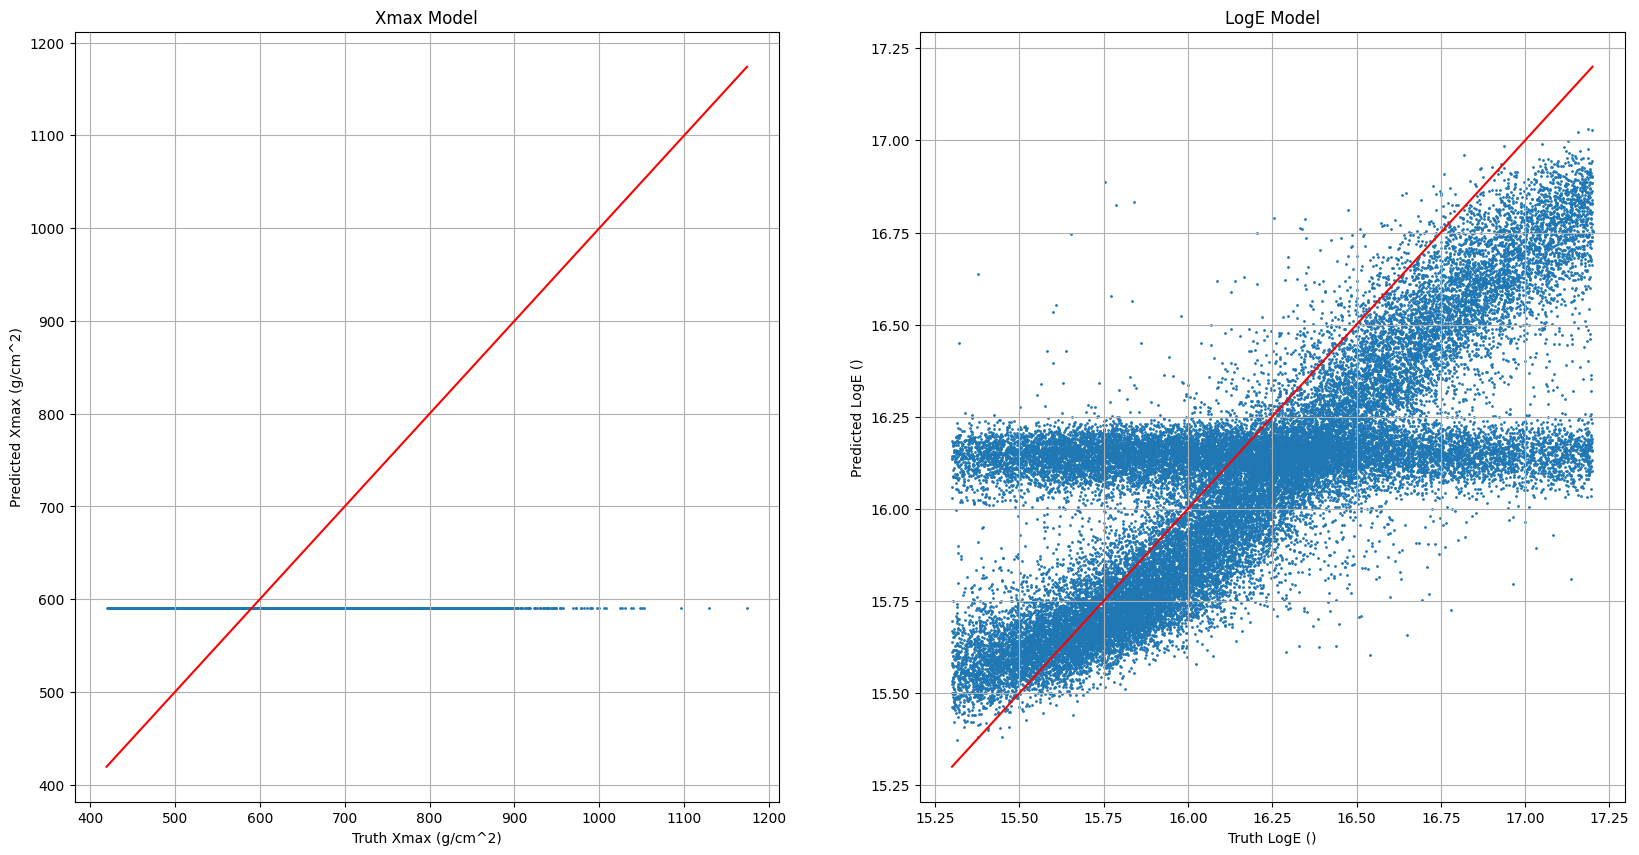

In [23]:
# Easy Scatter Plots of Predicted vs Truth
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units
if "SDPTheta_c" in TruthKeys and "SDPPhi_c" in TruthKeys:
    # The Unnormalise_Truth will return SDPTheta and SDPPhi values, not c/s of either
    TruthKeys  = ['SDPTheta','SDPPhi']
    TruthUnits = ['rad','rad']  # Default Units for SDPTheta and SDPPhi

fig, ax = plt.subplots(1, len(TruthKeys), figsize=(10*len(TruthKeys), 10))

for i in range(len(TruthKeys)):
    ax[i].scatter(Truth[:, i], Pred[:, i], s=1)
    ax[i].plot([min(Truth[:, i]), max(Truth[:, i])], [min(Truth[:, i]), max(Truth[:, i])], 'r')
    if TruthUnits[i] == 'rad': # Change to degrees
        xticks = ax[i].get_xticks()
        ax[i].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
        yticks = ax[i].get_yticks()
        ax[i].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} (deg)')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} (deg)')
    else:
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} ({TruthUnits[i]})')
    ax[i].set_title(f'{TruthKeys[i]} Model')
    ax[i].grid()

plt.show()


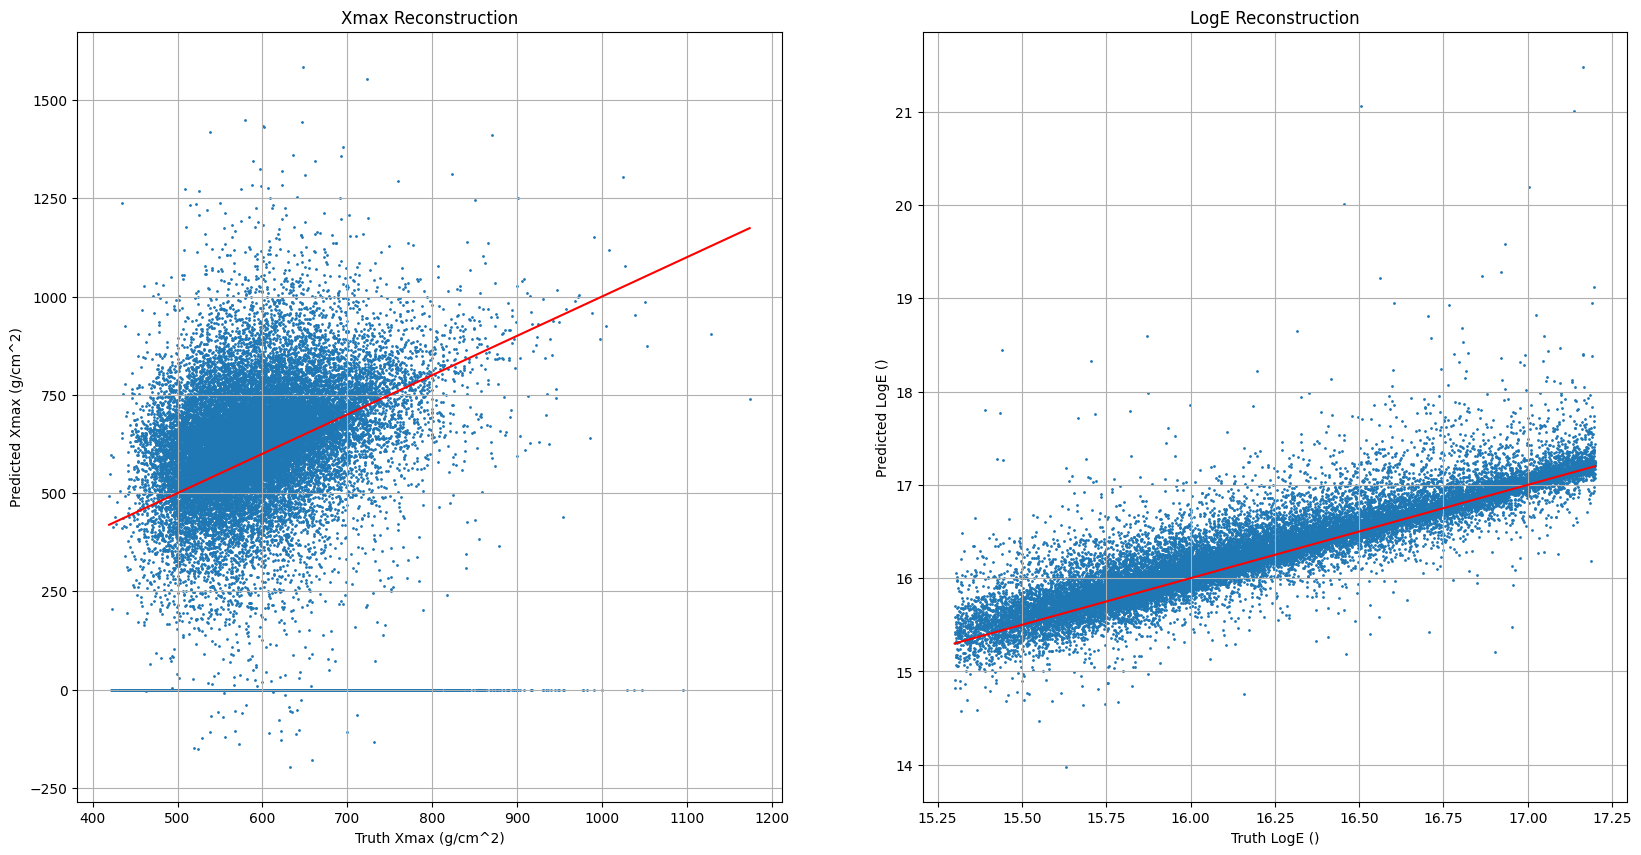

In [24]:
# Easy Scatter Plots of Reconstructed vs Truth
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units
if "SDPTheta_c" in TruthKeys and "SDPPhi_c" in TruthKeys:
    # The Unnormalise_Truth will return SDPTheta and SDPPhi values, not c/s of either
    TruthKeys  = ['SDPTheta','SDPPhi']
    TruthUnits = ['rad','rad']  # Default Units for SDPTheta and SDPPhi
    
fig, ax = plt.subplots(1, len(TruthKeys), figsize=(10*len(TruthKeys), 10))

for i in range(len(TruthKeys)):
    ax[i].scatter(Truth[:, i], Rec[:, i], s=1)
    ax[i].plot([min(Truth[:, i]), max(Truth[:, i])], [min(Truth[:, i]), max(Truth[:, i])], 'r')
    if TruthUnits[i] == 'rad': # Change to degrees
        xticks = ax[i].get_xticks()
        ax[i].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
        yticks = ax[i].get_yticks()
        ax[i].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} (deg)')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} (deg)')
    else:
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} ({TruthUnits[i]})')
    ax[i].set_title(f'{TruthKeys[i]} Reconstruction')
    ax[i].grid()

plt.show()


#### More Interesting plots

In [25]:
from matplotlib.colors import LinearSegmentedColormap

# Create a truncated version of the inferno colormap (first 90%)
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        f'truncated_{cmap.name}', 
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

# Original inferno colormap
inferno = plt.get_cmap('inferno_r')

# Truncated colormap: first 90%
truncated_inferno = truncate_colormap(inferno, 0.05, 1)


Total Points before cuts 37592
Xmax Total Points after cuts 23114
LogE Total Points after cuts 27288


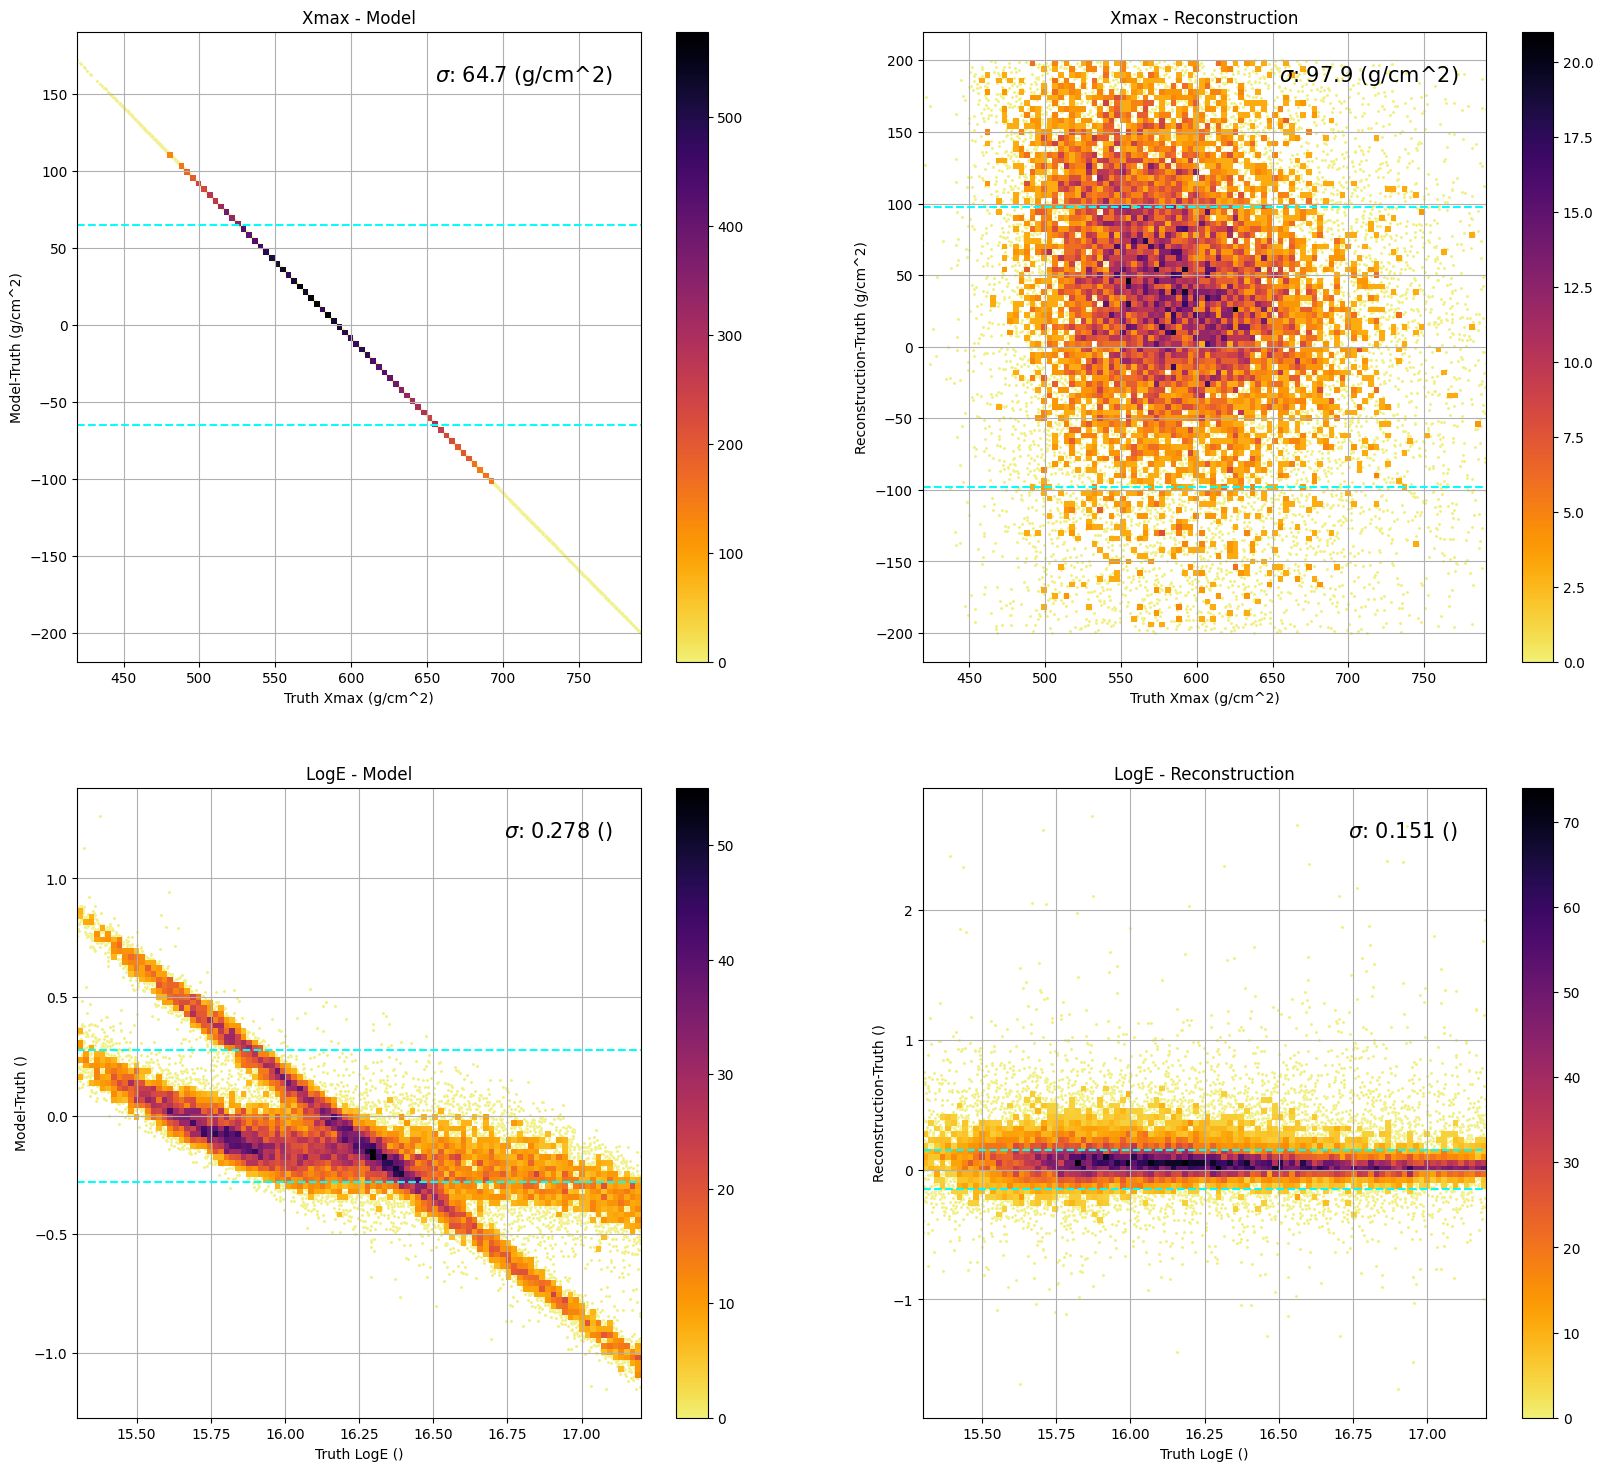

In [26]:
def CombinedDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec):
    plt.style.use('default')
    fig, ax = plt.subplots(len(TruthKeys),2, figsize=(20,9*len(TruthKeys)))
    print(f'Total Points before cuts {len(Truth)}')
    for i in range(len(TruthKeys)):
        X  = Truth[:, i] if TruthUnits[i] != 'rad' else Truth[:, i]/np.pi*180
        Yp = Pred[:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Pred[:, i] - Truth[:, i])/np.pi*180
        Yr = Rec [:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Rec [:, i] - Truth[:, i])/np.pi*180
        
        # Scaling Cuts
        if   TruthKeys[i] == 'SDPTheta': cut = (np.abs(Yp)>0) #  (np.abs(Yp)<20)    & (np.abs(Yr)<20)
        elif TruthKeys[i] == 'SDPPhi'  : cut = (np.abs(Yp)>0) #  (np.abs(Yp)<20)    & (np.abs(Yr)<20) #   & (np.abs(X)<50)
        elif TruthKeys[i] == 'Chi0'    : cut = (np.abs(Yp)<20)    & (np.abs(Yr)<20)
        elif TruthKeys[i] == 'Rp'      : cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        elif TruthKeys[i] == 'CEDist'  : cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        elif TruthKeys[i] == 'T0'      : cut = (np.abs(Yp)<10000) & (np.abs(Yr)<10000)
        elif TruthKeys[i] == 'Xmax'    : cut = (np.abs(Yp)<200)   & (np.abs(Yr)<200)  & (X>100)
        elif TruthKeys[i] == 'LogE'    : cut = (X>0)              & (np.abs(Yp)<3)    & (np.abs(Yr)<3)
        elif TruthKeys[i] == 'z'       : cut = (X>0.4) 
        else: cut = (np.abs(Yp)>0)

        
        X = X[cut]
        Yp = Yp[cut]
        Yr = Yr[cut]

        # Secondary Y_lim cuts for scaling
        # Yp_STD = np.percentile(np.abs(Yp),68)
        # cut = (np.abs(Yp)<5*Yp_STD) & (np.abs(Yr)<5*Yp_STD)
        # X  = X [cut]
        # Yp = Yp[cut]
        # Yr = Yr[cut]
        print(f'{TruthKeys[i]} Total Points after cuts {len(X)}')
        # sns.scatterplot(x=X, y=Yp, ax=ax[i,0], s=5,color='orange')
        # sns.scatterplot(x=X, y=Yr, ax=ax[i,1], s=5,color='orange')

        sns.scatterplot(x=X, y=Yp, ax=ax[i,0], s=5,color=truncated_inferno(0))
        sns.scatterplot(x=X, y=Yr, ax=ax[i,1], s=5,color=truncated_inferno(0))


        sns.histplot(x=X, y=Yp, ax=ax[i,0], bins=100, pthresh=0.1,cmap = truncated_inferno,cbar = True)
        sns.histplot(x=X, y=Yr, ax=ax[i,1], bins=100, pthresh=0.1,cmap = truncated_inferno,cbar = True)
        if TruthUnits[i] != 'rad': 
            ax[i,0].set_ylabel(f'Model-Truth ({TruthUnits[i]})')
            ax[i,0].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            ax[i,1].set_ylabel(f'Reconstruction-Truth ({TruthUnits[i]})')
            ax[i,1].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            
        else:                      
            ax[i,0].set_ylabel(f'Model-Truth (degrees)')
            ax[i,0].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')

            ax[i,1].set_ylabel(f'Reconstruction-Truth (degrees)')
            ax[i,1].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')
        
        ax[i,0].set_title(f'{TruthKeys[i]} - Model')
        ax[i,1].set_title(f'{TruthKeys[i]} - Reconstruction')

        ax[i,0].set_xlim(min(X),max(X))
        ax[i,1].set_xlim(min(X),max(X))

        ax[i,0].grid()
        ax[i,1].grid()

        # ax[0,1].set_facecolor('lightgrey')
        # ax[1,1].set_facecolor('lightgrey')


        # 68th Percentile
        Percentile68_p = np.percentile(np.abs(Yp),68)
        Percentile68_r = np.percentile(np.abs(Yr),68)

        # ax[i,0].set_ylim(-Percentile68_p*5,Percentile68_p*5)
        # ax[i,1].set_ylim(-Percentile68_p*5,Percentile68_p*5)



        # Add as a texbox to top right of plot
        if TruthUnits[i]!= 'rad':
            ax[i,0].text(0.95, 0.95, f'$\\sigma$: {Percentile68_p:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[i,0].transAxes, fontsize=15)
            ax[i,1].text(0.95, 0.95, f'$\\sigma$: {Percentile68_r:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[i,1].transAxes, fontsize=15)

        else:
            ax[i,0].text(0.95, 0.95, f'$\\sigma$: {Percentile68_p:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[i,0].transAxes, fontsize=15)
            ax[i,1].text(0.95, 0.95, f'$\\sigma$: {Percentile68_r:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[i,1].transAxes, fontsize=15)



        ax[i,0].axhline(Percentile68_p, color='cyan', linestyle='--')
        ax[i,0].axhline(-Percentile68_p, color='cyan', linestyle='--')

        ax[i,1].axhline(Percentile68_r, color='cyan', linestyle='--')
        ax[i,1].axhline(-Percentile68_r, color='cyan', linestyle='--')
        
    return fig
    
figure = CombinedDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec)
# figure.savefig(f'../Results/{Model_Name}_Combined_Deviation.png')

#### Figure out what doesn't work

In [27]:
# Compute the Test Set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
Model.to(device)
torch.cuda.empty_cache()

Dataset.State      = 'Test'
# Dataset.BatchSize  = len(Dataset)//256
Dataset.BatchSize  = 64
Dataset.RandomIter = False
Truth = []
Pred  = []
Rec   = []
Aux   = []

Model.eval()
EvI = 0
with torch.no_grad():
    for EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec in Dataset:
        # print(f'Event {EvI}/{len(Dataset)}', end='\r')
        # Send to device
        # BatchMains = [Main.to(device) for Main in BatchMains]
        # BatchAux   = BatchAux.to(device)
        # BatchAux[] = Dataset._Aux.mean(dim=0)

        Truth .append(BatchTruth)
        Pred  .append(Model(BatchMains, BatchAux).cpu())
        Rec   .append(BatchRec)
        Aux   .append(BatchAux)
        EvI+=1

print()
Truth = torch.cat(Truth, dim=0)
Pred  = torch.cat(Pred , dim=0)
Rec   = torch.cat(Rec  , dim=0)
Aux   = torch.cat(Aux  , dim=0)

print(f'Pred Loss {MeanSquaredError(Truth,Pred)}')
print(f'Rec  Loss {MeanSquaredError(Truth,Rec )}')

Truth = Dataset.Unnormalise_Truth(Truth)
Pred  = Dataset.Unnormalise_Truth(Pred)
Rec   = Dataset.Unnormalise_Truth(Rec)


if len(Aux.shape) == 3:
    Aux = Aux.squeeze()  # Add a dimension if Aux is 1D

Truth = Truth.numpy()
Pred  = Pred .numpy()
Rec   = Rec  .numpy()
Aux   = Aux  .numpy()

print(Truth.shape)
print(Pred.shape)
print(Rec.shape)
print(Aux.shape)

AuxKeys = ['Event_Class','Primary','Gen_LogE','Gen_CosZenith','Gen_Xmax','Gen_Chi0','Gen_Rp']
print('Auxiliary Keys:', AuxKeys)


Pred Loss 0.7461493611335754
Rec  Loss inf
(37592, 2)
(37592, 2)
(37592, 2)
(37592, 7)
Auxiliary Keys: ['Event_Class', 'Primary', 'Gen_LogE', 'Gen_CosZenith', 'Gen_Xmax', 'Gen_Chi0', 'Gen_Rp']


In [28]:
# Figuring out the default energy prediction of events

Pred_Xmax = Pred[:,0]
Pred_LogE = Pred[:,1]

Truth_Xmax = Truth[:,0]
Truth_LogE = Truth[:,1]

Rec_Xmax  = Rec [:,0]
Rec_LogE  = Rec [:,1]

# Create a mask of events which have a mean value for energy prediction where the true value isnt

Mask_Pred_default = (Pred_LogE > 16) & (Pred_LogE < 16.25)
Mask_Truth_mean   = (Truth_LogE < 15.75) | (Truth_LogE > 16.5)

Mask = Mask_Pred_default & Mask_Truth_mean


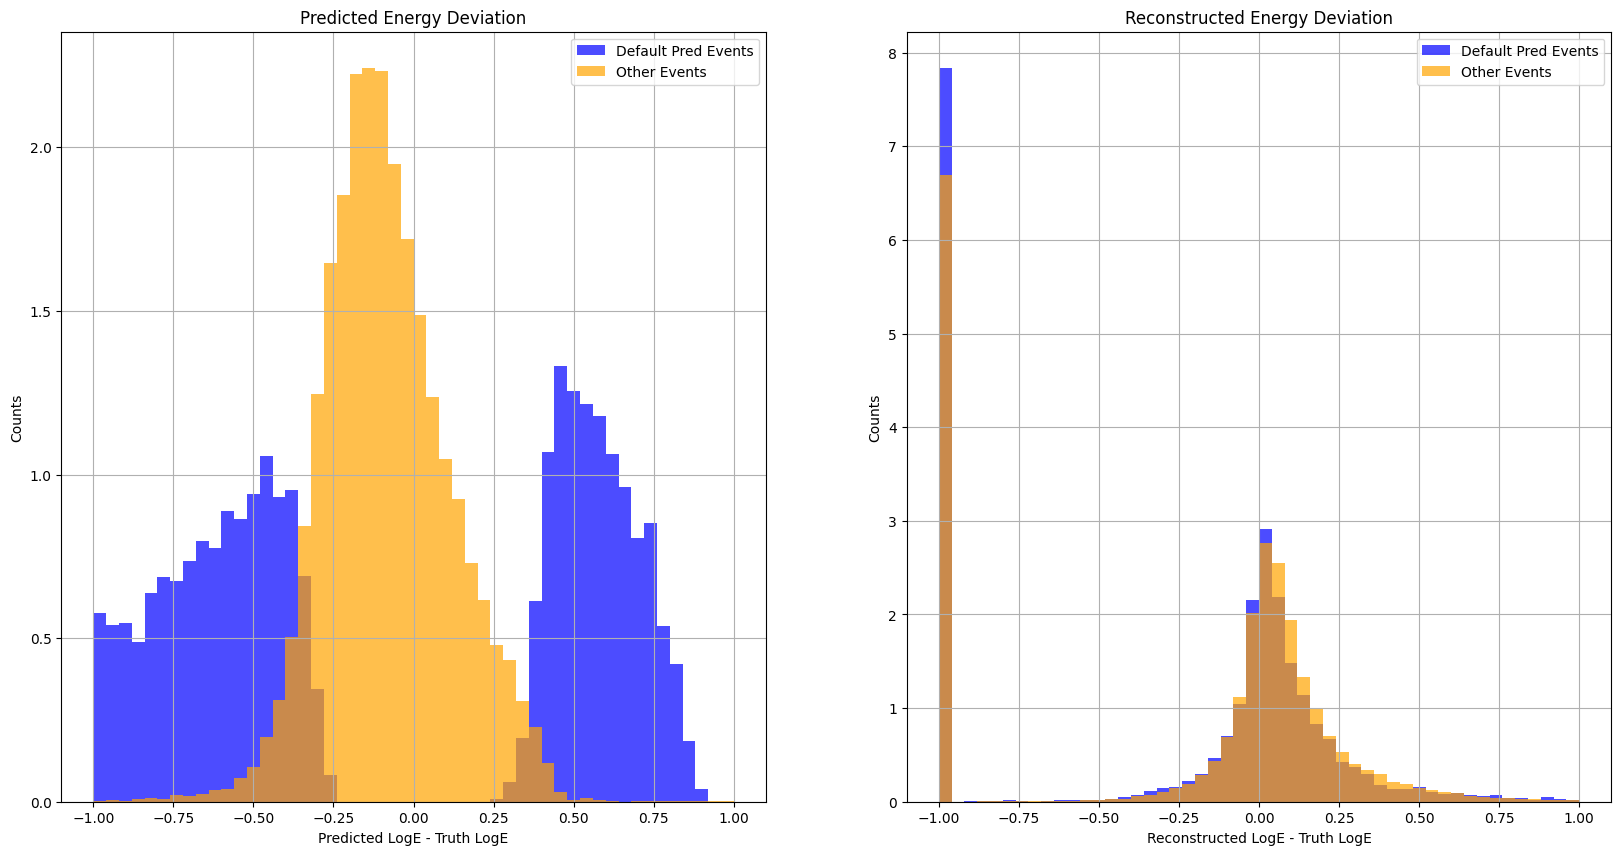

In [29]:
# lets see what the distribution of these events is for Rec First

fig, ax = plt.subplots(1,2,figsize=(20,10))

X = Pred_LogE - Truth_LogE

ax[0].hist(X[ Mask], bins=50, range = [-1,1], color='blue', alpha=0.7, label='Default Pred Events',density=True)
ax[0].hist(X[~Mask], bins=50, range = [-1,1], color='orange', alpha=0.7, label='Other Events',density=True)
ax[0].set_title('Predicted Energy Deviation')
ax[0].set_xlabel('Predicted LogE - Truth LogE')
ax[0].set_ylabel('Counts')
ax[0].legend()
ax[0].grid()

# Now for Rec
X = Rec_LogE - Truth_LogE
# Set Nans to 0
X[np.isnan(X)|np.isinf(X)] = -1
ax[1].hist(X[ Mask], bins=50, range = [-1,1], color='blue', alpha=0.7, label='Default Pred Events',density=True)
ax[1].hist(X[~Mask], bins=50, range = [-1,1], color='orange', alpha=0.7, label='Other Events',density=True)
ax[1].set_title('Reconstructed Energy Deviation')
ax[1].set_xlabel('Reconstructed LogE - Truth LogE')
ax[1].set_ylabel('Counts')
ax[1].legend()
ax[1].grid()


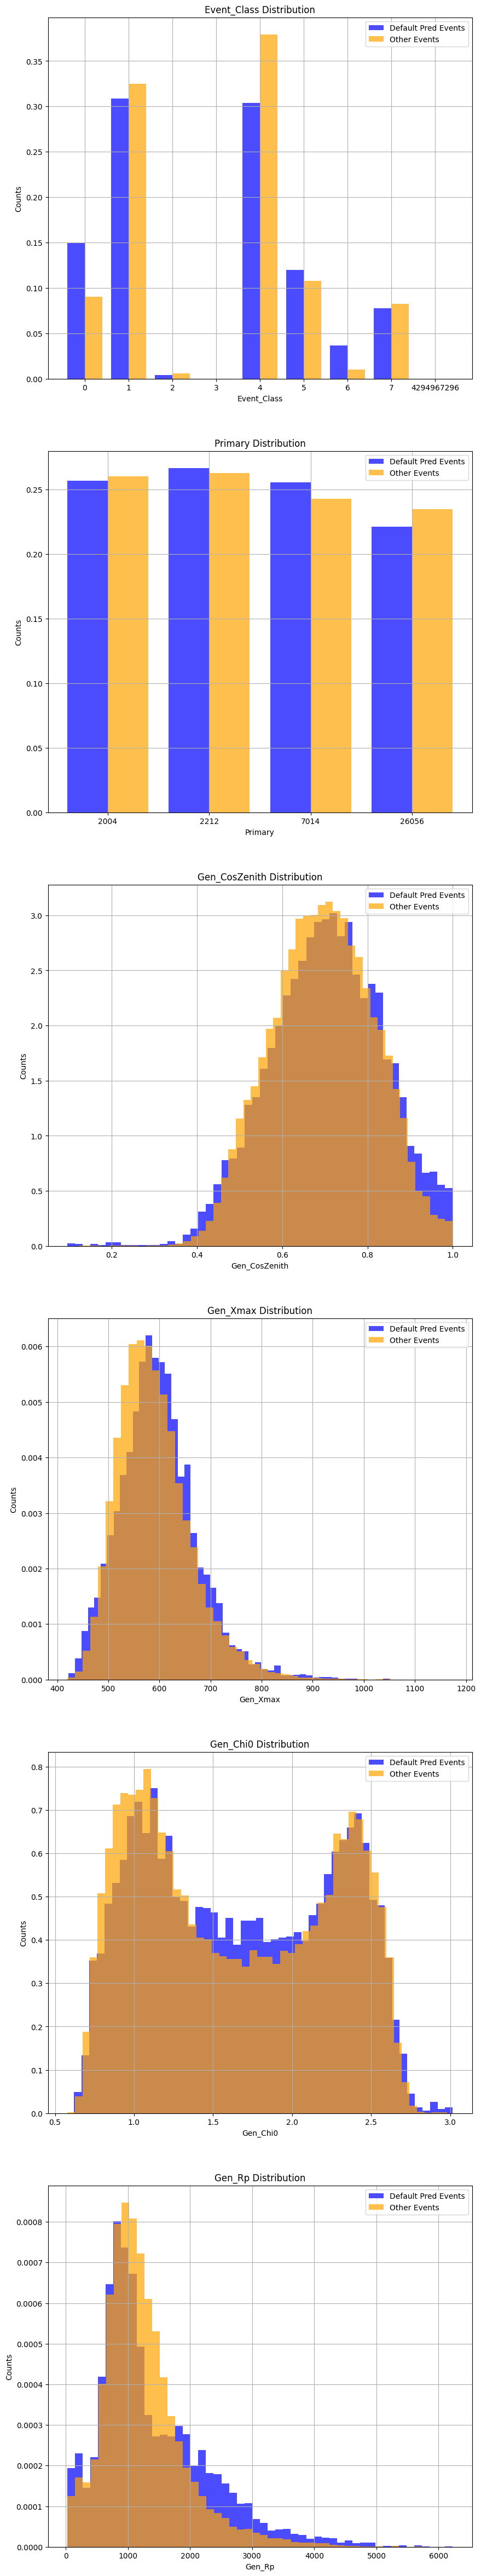

In [30]:
# now lets see how the aux variables of these events compare to the rest
Aux_vars_of_interest = ['Event_Class', 'Primary','Gen_CosZenith', 'Gen_Xmax', 'Gen_Chi0', 'Gen_Rp']

fig, ax = plt.subplots(len(Aux_vars_of_interest),1,figsize=(10,10*len(Aux_vars_of_interest)))
for i in range(len(Aux_vars_of_interest)):
    Var = Aux[:,AuxKeys.index(Aux_vars_of_interest[i])]
    if Aux_vars_of_interest[i] in ['Event_Class','Primary']:
        # Categorical Plot
        Categories = np.unique(Var)
        Counts_Default = [(Var[Mask]==cat).sum() / Mask.sum() for cat in Categories]
        Counts_Other   = [(Var[~Mask]==cat).sum() / (~Mask).sum() for cat in Categories]

        ax[i].bar(np.arange(len(Categories))-0.2, Counts_Default, width=0.4, color='blue', alpha=0.7, label='Default Pred Events')
        ax[i].bar(np.arange(len(Categories))+0.2, Counts_Other  , width=0.4, color='orange', alpha=0.7, label='Other Events')
        ax[i].set_xticks(np.arange(len(Categories)))
        ax[i].set_xticklabels([str(int(cat)) for cat in Categories])
        ax[i].set_xlabel(Aux_vars_of_interest[i])
        ax[i].set_ylabel('Counts')
        ax[i].set_title(f'{Aux_vars_of_interest[i]} Distribution')
        ax[i].legend()
        ax[i].grid()

        
    else:
        # Continuous Plot
        ax[i].hist(Var[ Mask], bins=50, color='blue', alpha=0.7, label='Default Pred Events',density=True)
        ax[i].hist(Var[~Mask], bins=50, color='orange', alpha=0.7, label='Other Events',density=True)
        ax[i].set_title(f'{Aux_vars_of_interest[i]} Distribution')
        ax[i].set_xlabel(Aux_vars_of_interest[i])
        ax[i].set_ylabel('Counts')
        ax[i].legend()
        ax[i].grid()

In [31]:
All_Event_IDs = Dataset._EventIds
Dataset_active_indices = Dataset.ActiveIndeces

All_Event_IDs = np.array(All_Event_IDs)[Dataset_active_indices]


# # Check if the EventID Column is in the DataFrame
# if 'EventID' in EventLevelData.columns:
#     # Means this cell has been run before
#     # I need to replace the EventID column with the EventId_1 and EventId_2 columns
#     EventLevelData['EventID_1/2'] = EventLevelData['EventID'].apply(lambda x: int(x.split(':')[0].split('_')[1][-6:]))
#     EventLevelData['EventID_2/2'] = EventLevelData['EventID'].apply(lambda x: int(x.split(':')[1].split('_')[1]))
#     # Drop the EventId column
#     EventLevelData = EventLevelData.drop(columns=['EventID'])
#     # Move the EventId_1 and EventId_2 columns to the front
#     EventLevelData = EventLevelData[['EventID_1/2', 'EventID_2/2'] + [col for col in EventLevelData.columns if col not in ['EventID_1/2', 'EventID_2/2']]]

# EventLevelData.head()

# Example of how original id looked like Batch_300001788:Shower_467
# Example of how the Dataset._EventIds is constructed ID = (Event.get_value('EventID_1/2').int()*10000 + Event.get_value('EventID_2/2').int()%10000).item()

All_Event_IDs_original = []
for ID in All_Event_IDs:
    Part1 = ID // 10000
    Part2 = ID %  10000
    Part1 += 300000000
    All_Event_IDs_original.append(f'Batch_{Part1:09d}:Shower_{Part2}')
# print(All_Event_IDs_original[:5])

# now apply the mask to the event ids
Default_Event_IDs = np.array(All_Event_IDs_original)[Mask]
print(Default_Event_IDs[:20])


['Batch_300086275:Shower_2789' 'Batch_300046552:Shower_1881'
 'Batch_300028938:Shower_6044' 'Batch_300003806:Shower_9328'
 'Batch_300013997:Shower_6850' 'Batch_300082352:Shower_4267'
 'Batch_300038137:Shower_4449' 'Batch_300018774:Shower_1304'
 'Batch_300007843:Shower_2465' 'Batch_300048937:Shower_3304'
 'Batch_300003438:Shower_1188' 'Batch_300033498:Shower_6008'
 'Batch_300048377:Shower_4545' 'Batch_300045893:Shower_8948'
 'Batch_300059882:Shower_7241' 'Batch_300031278:Shower_674'
 'Batch_300078201:Shower_1355' 'Batch_300061918:Shower_1219'
 'Batch_300017859:Shower_2785' 'Batch_300006966:Shower_5664']
